# Getting Started

Bambi requires a working Python interpreter (3.8+). We recommend installing Python and key numerical libraries using the [Anaconda Distribution](https://www.anaconda.com/products/individual), which has one-click installers available on all major platforms.

Assuming a standard Python environment is installed on your machine (including pip), Bambi itself can be installed in one line using pip:

    pip install bambi

Alternatively, if you want the bleeding edge version of the package, you can install from GitHub:

    pip install git+https://github.com/bambinos/bambi.git

## Quickstart

Suppose we have data for a typical within-subjects psychology experiment with 2 experimental conditions. Stimuli are nested within condition, and subjects are crossed with condition. We want to fit a model predicting reaction time (RT) from the common effect of condition, group specific intercepts for subjects, group specific condition slopes for students, and group specific intercepts for stimuli. Using Bambi we can fit this model and summarize its results as follows:

```python
import bambi as bmb

# Assume we already have our data loaded as a pandas DataFrame
model = bmb.Model("rt ~ condition + (condition|subject) + (1|stimulus)", data)
results = model.fit(draws=5000, chains=2)
az.plot_trace(results)
az.summary(results)
```

## User Guide

### Setup

In [1]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd

In [3]:
az.style.use("arviz-darkgrid")

### Creating a model

Creating a new model in Bambi is simple:

In [4]:
# Read in a tab-delimited file containing our data
data = pd.read_table("data/my_data.txt", sep="\t")

# Initialize the model
model = bmb.Model("y ~ x + z", data)

# Inspect model object
model

       Formula: y ~ x + z
        Family: gaussian
          Link: mu = identity
  Observations: 50
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1852, sigma: 2.5649)
            x ~ Normal(mu: 0.0, sigma: 2.231)
            z ~ Normal(mu: 0.0, sigma: 2.4374)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.013)

Typically, we will initialize a Bambi ``Model`` by passing it a model formula and a pandas ``DataFrame``. Other arguments such as family, priors, and link are available. By default, it uses ``family="gaussian"`` which implies a linear regression with normal error. We get back a model that we can immediately fit by calling ``model.fit()``.

### Data format

As with most mixed effect modeling packages, Bambi expects data in "long" format--meaning that each row should reflects a single observation at the most fine-grained level of analysis. For example, given a model where students are nested into classrooms and classrooms are nested into schools, we would want data with the following kind of structure:

<center>

|student| gender | gpa    |  class | school
|:-----:|:------:|:------:|:------:| :------:|
1       |F       |3.4     | 1      |1 |
2       |F       |3.7     | 1      |1 |
3       |M       |2.2     | 1      |1 |
4       |F       |3.9     | 2      |1 |
5       |M       |3.6     | 2      |1 |
6       |M       |3.5     | 2      |1 |
7       |F       |2.8     | 3      |2 |
8       |M       |3.9     | 3      |2 |
9       |F       |4.0     | 3      |2 |

</center>

## Formula-based specification

Models are specified in Bambi using a formula-based syntax similar to what one might find in R packages like lme4 or brms using the Python [formulae](https://github.com/bambinos/formulae) library. A couple of examples illustrate the breadth of models that can be easily specified in Bambi:

In [5]:
data = pd.read_csv("data/rrr_long.csv")
data.head(10)

,uid,condition,gender,age,study,self_perf,stimulus,value
0,1.0,0.0,1.0,24.0,0.0,8.0,rating_c1,3.0
1,2.0,1.0,0.0,27.0,0.0,9.0,rating_c1,7.0
2,3.0,0.0,1.0,25.0,0.0,3.0,rating_c1,5.0
3,5.0,0.0,1.0,20.0,0.0,3.0,rating_c1,7.0
4,8.0,1.0,1.0,19.0,0.0,6.0,rating_c1,6.0
5,9.0,0.0,1.0,22.0,0.0,3.0,rating_c1,6.0
6,10.0,1.0,1.0,49.0,0.0,4.0,rating_c1,6.0
7,11.0,0.0,0.0,24.0,0.0,5.0,rating_c1,7.0
8,12.0,1.0,0.0,26.0,0.0,6.0,rating_c1,2.0
9,13.0,0.0,1.0,23.0,0.0,7.0,rating_c1,1.0


In [6]:
# Number of rows with missing values
data.isna().any(axis=1).sum()

401

We pass ``dropna=True`` to tell Bambi to drop rows containing missing values. The number of rows dropped is different from the number of rows with missing values because Bambi only considers columns involved in the model.

In [7]:
# Common (or fixed) effects only
bmb.Model("value ~ condition + age + gender", data, dropna=True)

Automatically removing 33/6940 rows from the dataset.


       Formula: value ~ condition + age + gender
        Family: gaussian
          Link: mu = identity
  Observations: 6907
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 4.5457, sigma: 28.4114)
            condition ~ Normal(mu: 0.0, sigma: 12.0966)
            age ~ Normal(mu: 0.0, sigma: 1.3011)
            gender ~ Normal(mu: 0.0, sigma: 13.1286)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 2.4186)

In [8]:
# Common effects and group specific (or random) intercepts for subject
bmb.Model("value ~ condition + age + gender + (1|uid)", data, dropna=True)

Automatically removing 33/6940 rows from the dataset.


       Formula: value ~ condition + age + gender + (1|uid)
        Family: gaussian
          Link: mu = identity
  Observations: 6907
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 4.5457, sigma: 28.4114)
            condition ~ Normal(mu: 0.0, sigma: 12.0966)
            age ~ Normal(mu: 0.0, sigma: 1.3011)
            gender ~ Normal(mu: 0.0, sigma: 13.1286)
        
        Group-level effects
            1|uid ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 28.4114))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 2.4186)

In [9]:
# Multiple, complex group specific effects with both
# group specific slopes and group specific intercepts
bmb.Model(
    "value ~ condition + age + gender + (1|uid) + (condition|study) + (condition|stimulus)", 
    data, 
    dropna=True
)

Automatically removing 33/6940 rows from the dataset.


       Formula: value ~ condition + age + gender + (1|uid) + (condition|study) + (condition|stimulus)
        Family: gaussian
          Link: mu = identity
  Observations: 6907
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 4.5457, sigma: 28.4114)
            condition ~ Normal(mu: 0.0, sigma: 12.0966)
            age ~ Normal(mu: 0.0, sigma: 1.3011)
            gender ~ Normal(mu: 0.0, sigma: 13.1286)
        
        Group-level effects
            1|uid ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 28.4114))
            1|study ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 28.4114))
            condition|study ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 12.0966))
            1|stimulus ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 28.4114))
            condition|stimulus ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 12.0966))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 2.4186)

Each of the above examples specifies a full model that can be fitted using PyMC by doing

```python
results = model.fit()
```

### Coding of categorical variables

When a categorical common effect with N levels is added to a model, by default, it is coded by N-1 dummy variables (i.e., reduced-rank coding). For example, suppose we write ``"y ~ condition + age + gender"``, where condition is a categorical variable with 4 levels, and age and gender are continuous variables. Then our model would contain an intercept term (added to the model by default, as in R), three dummy-coded variables (each contrasting the first level of ``condition`` with one of the subsequent levels), and continuous predictors for age and gender. Suppose, however, that we would rather use full-rank coding of conditions. If we explicitly remove the intercept --as in ``"y ~ 0 + condition + age + gender"``-- then we get the desired effect. Now, the intercept is no longer included, and condition will be coded using 4 dummy indicators, each one coding for the presence or absence of the respective condition without reference to the other conditions.

Group specific effects are handled in a comparable way. When adding group specific intercepts, coding is always full-rank (e.g., when adding group specific intercepts for 100 schools, one gets 100 dummy-coded indicators coding each school separately, and not 99 indicators contrasting each school with the very first one). For group specific slopes, coding proceeds the same way as for common effects. The group specific effects specification ``"(condition|subject)"`` would add an intercept for each subject, plus N-1 condition slopes (each coded with respect to the first, omitted, level as the referent). If we instead specify ``"(0+condition|subject)"``, we get N condition slopes and no intercepts.

### Fitting the model

Once a model is fully specified, we need to run the PyMC sampler to generate parameter estimates. If we're using the one-line ``fit()`` interface, sampling will begin right away:

In [10]:
model = bmb.Model("value ~ condition + age + gender + (1|uid)", data, dropna=True)
results = model.fit()

Automatically removing 33/6940 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sigma, Intercept, condition, age, gender, 1|uid_sigma, 1|uid_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


The above code obtains 1,000 draws (the default value) and return them as an ``InferenceData`` instance. 

::: {.callout-tip}
InferenceData is a rich data structure to store and manipulate data such as posterior samples, prior/posterior predictive samples, observations, etc. It is based on [xarray](https://docs.xarray.dev/en/stable/), a library offering N-dimensional labeled arrays (you can think of it as a generalization of both Numpy arrays and Pandas dataframes).
To learn how to perform common operations with InferenceData, like indexing, selection etc please check [this](https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html) and for details of the InferenceData Schema see this [specification](https://python.arviz.org/en/latest/schema/schema.html).
:::


In this case, the `fit()` method accepts optional keyword arguments to pass onto PyMC's ``sample()`` method, so any methods accepted by ``sample()`` can be specified here. We can also explicitly set the number of draws via the ``draws`` argument. For example, if we call ``fit(draws=2000, chains=2)``, the PyMC sampler will sample two chains in parallel, drawing 2,000 draws for each one. We could also specify starting parameter values, the step function to use, and so on (for full details, see the [PyMC documentation](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html#pymc.sample)).


Alternatively, we can build a model, but not fit it.

In [11]:
model = bmb.Model("value ~ condition + age + gender + (1|uid)", data, dropna=True)
model.build()

Automatically removing 33/6940 rows from the dataset.


Building without sampling can be useful if we want to inspect the internal PyMC model before we start the (potentially long) sampling process. Once we're satisfied, and wish to run the sampler, we can then simply call ``model.fit()``, and the sampler will start running. Another good reason to build a model is to generate plot of the marginal priors using `model.plot_priors()`.

Sampling: [1|uid_sigma, Intercept, age, condition, gender, value_sigma]


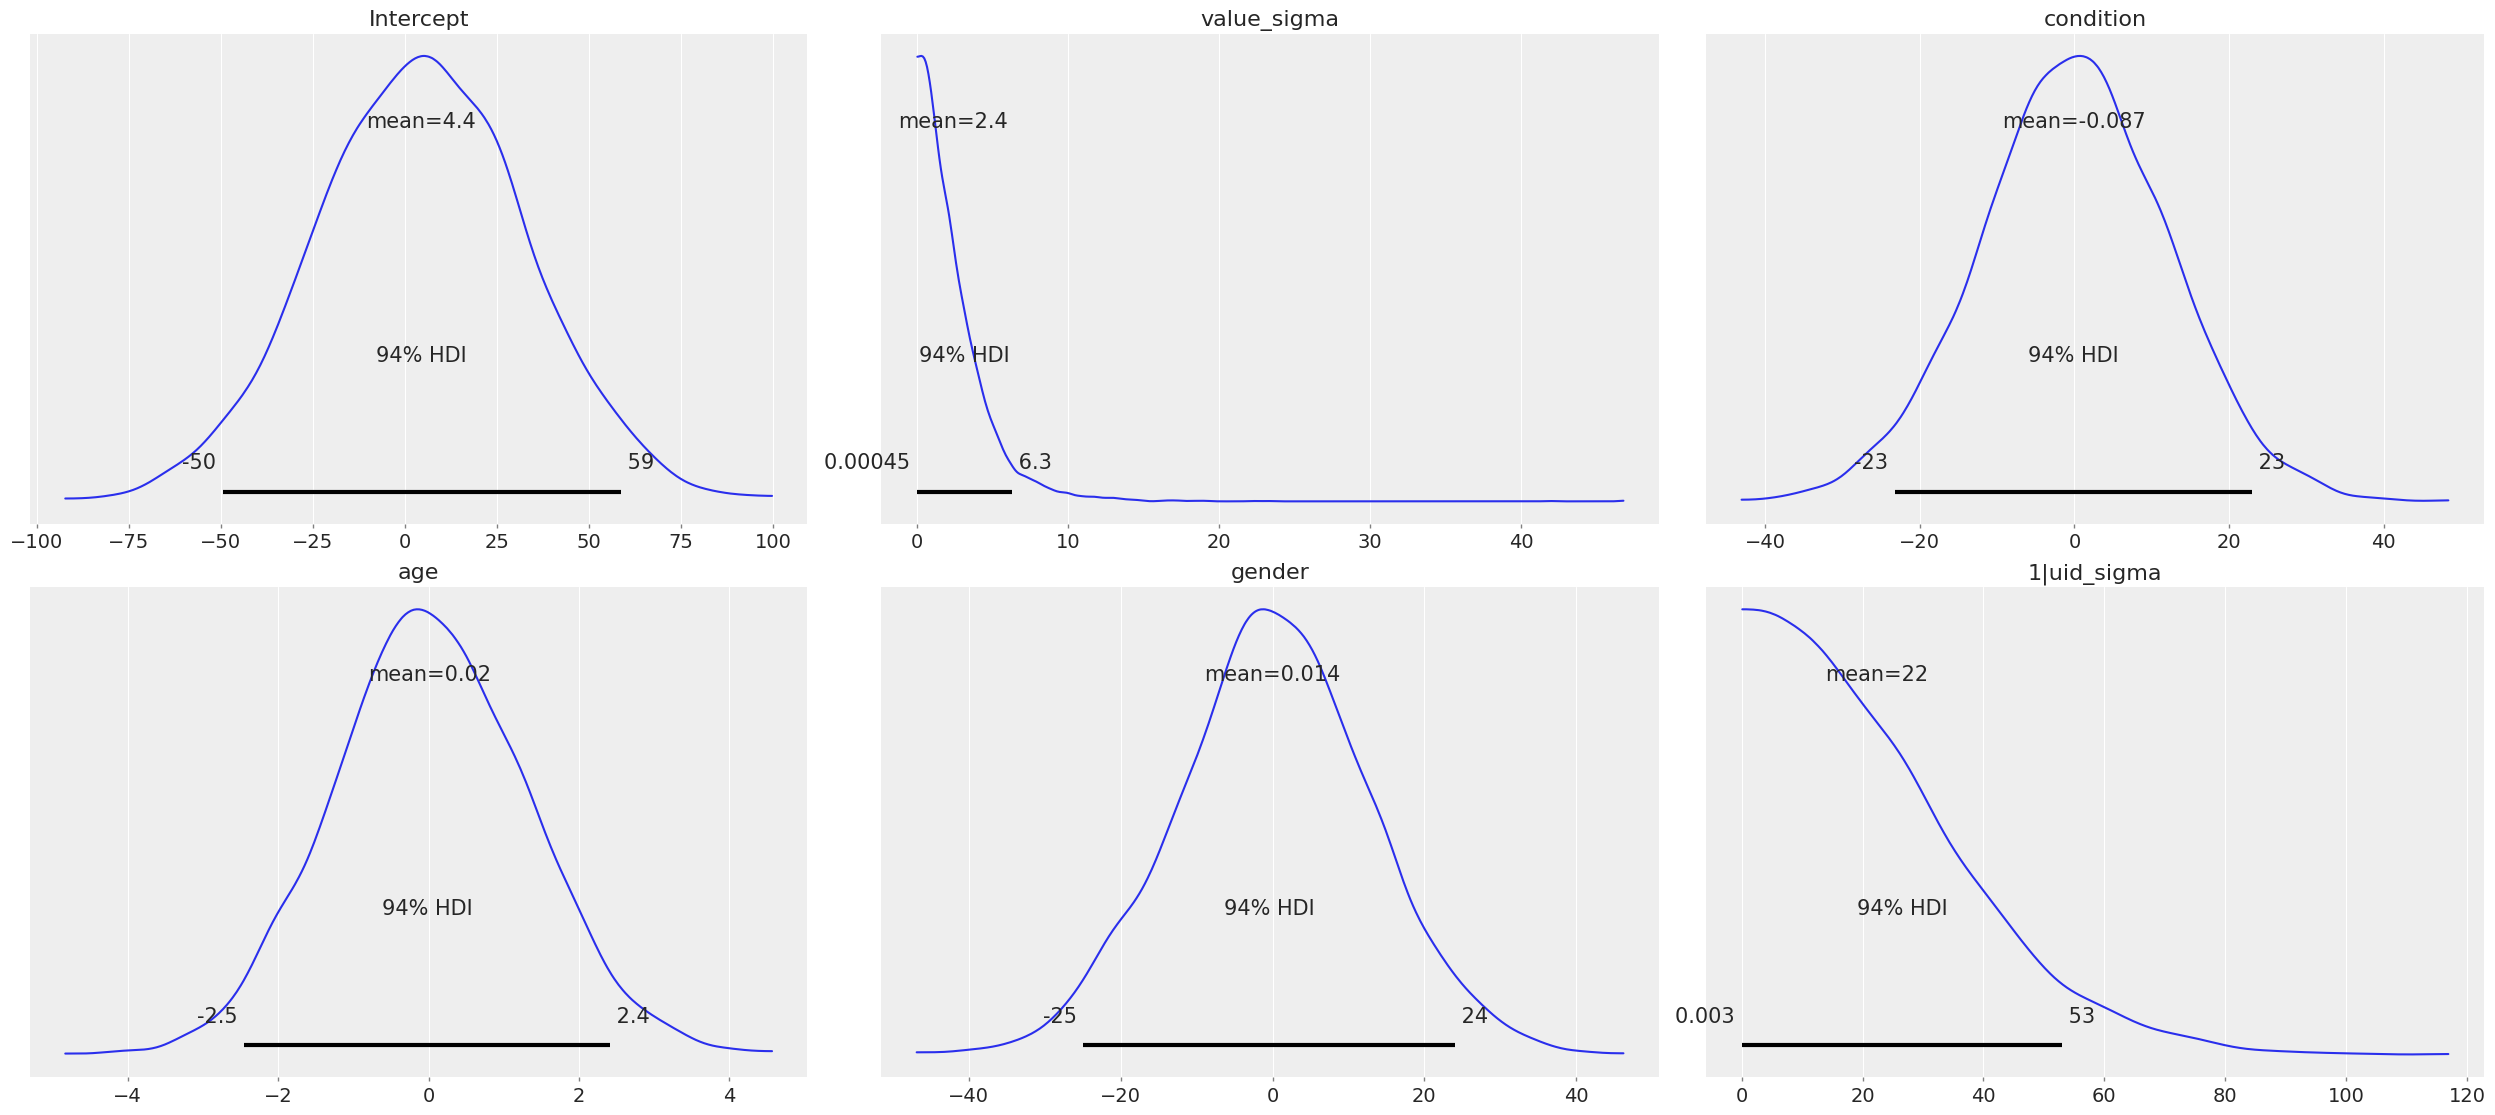

In [12]:
model.plot_priors();

## Specifying priors


Bayesian inference requires one to specify prior probability distributions that represent the analyst's belief (in advance of seeing the data) about the likely values of the model parameters. In practice, analysts often lack sufficient information to formulate well-defined priors, and instead opt to use "weakly informative" priors that mainly serve to keep the model from exploring completely pathological parts of the parameter space (e.g., when defining a prior on the distribution of human heights, a value of 3,000 cms should be assigned a probability of exactly 0).

By default, Bambi will intelligently generate weakly informative priors for all model terms, by loosely scaling them to the observed data. Currently, Bambi uses a methodology very similar to the one described in the documentation of the R package [rstanarm](https://mc-stan.org/rstanarm/articles/priors.html). While the default priors will behave well in most typical settings, there are many cases where an analyst will want to specify their own priors--and in general, when informative priors are available, it's a good idea to use them.

Fortunately, Bambi is built on top of PyMC, which means that we can seamlessly use any of the over 40 ``Distribution`` classes defined in PyMC. We can specify such priors in Bambi using the ``Prior`` class, which initializes with a ``name`` argument (which must map on exactly to the name of a valid PyMC ``Distribution``) followed by any of the parameters accepted by the corresponding ``distribution``. For example:

In [13]:
# A Laplace prior with mean of 0 and scale given by a HalfNormal with a scale of 1
my_favorite_prior = bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=1))

# Set the prior when adding a term to the model; more details on this below.
priors = {"1|uid": my_favorite_prior}
bmb.Model("value ~ condition + (1|uid)", data, priors=priors, dropna=True)

Automatically removing 9/6940 rows from the dataset.


       Formula: value ~ condition + (1|uid)
        Family: gaussian
          Link: mu = identity
  Observations: 6931
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 4.5516, sigma: 8.4548)
            condition ~ Normal(mu: 0.0, sigma: 12.1019)
        
        Group-level effects
            1|uid ~ Laplace(mu: 0.0, b: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 2.4197)

Priors specified using the ``Prior`` class can be nested to arbitrary depths--meaning, we can set any of a given prior's argument to point to another ``Prior`` instance. This is particularly useful when specifying hierarchical priors on group specific effects, where the individual group specific slopes or intercepts are constrained to share a common source distribution:

In [14]:
subject_sd = bmb.Prior("HalfCauchy", beta=5)
subject_prior = bmb.Prior("Normal", mu=0, sd=subject_sd)
priors = {"1|uid": subject_prior}
bmb.Model("value ~ condition + (1|uid)", data, priors=priors, dropna=True)

Automatically removing 9/6940 rows from the dataset.


       Formula: value ~ condition + (1|uid)
        Family: gaussian
          Link: mu = identity
  Observations: 6931
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 4.5516, sigma: 8.4548)
            condition ~ Normal(mu: 0.0, sigma: 12.1019)
        
        Group-level effects
            1|uid ~ Normal(mu: 0.0, sd: HalfCauchy(beta: 5.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 2.4197)

The above prior specification indicates that the individual subject intercepts are to be treated as if they are randomly sampled from the same underlying normal distribution, where the variance of that normal distribution is parameterized by a separate hyperprior (a half-cauchy with beta = 5).

It's important to note that explicitly setting priors by passing in ``Prior`` objects will disable Bambi's default behavior of scaling priors to the data in order to ensure that they remain weakly informative. This means that if you specify your own prior, you have to be sure not only to specify the distribution you want, but also any relevant scale parameters. For example, the 0.5 in ``Prior("Normal", mu=0, sd=0.5)`` will be specified on the scale of the data, not the bounded partial correlation scale that Bambi uses for default priors. This means that if your outcome variable has a mean value of 10,000 and a standard deviation of, say, 1,000, you could potentially have some problems getting the model to produce reasonable estimates, since from the perspective of the data, you're specifying an extremely strong prior.

### Custom Prior

Bambi's priors are a thin layer on top of [PyMC distributions](https://www.pymc.io/projects/docs/en/latest/api/distributions.html). If you want to ask for a prior distribution by name, it must be the name of a PyMC distribution. But sometimes we want to use more complex distributions as priors. For all those cases, Bambi's `Prior` class allow users to pass a function that returns a distribution that will be used as the prior. See the following example:

```python
def CustomPrior(name, *args, dims=None, **kwargs):
    return pm.Normal(name, *args, dims=dims, **kwargs)

priors = {"x": Prior("CustomPrior", mu=0, sigma=5, dist=CustomPrior)}
model = Model("y ~ x", data, priors=priors)
```

The example above is trival because it's just a wrapper of the `pm.Normal` distribution. But we can use this pattern to construct more complex distributions, such as a Truncated Laplace distribution shown below.

```python
def TruncatedLaplace(name, mu,b,lower,upper,*args, dims=None, **kwargs):
    lap_dist = pm.Laplace.dist(mu=mu, b=b)
    return pm.Truncated(name, lap_dist, lower=lower, upper=upper, *args, dims=dims, **kwargs)
```

In summary, custom priors allow for greater flexibility by combining existing PyMC distributions in different ways. If you need to use a distribution that's not implemented in PyMC, please check the [link](https://www.pymc.io/projects/docs/en/latest/contributing/implementing_distribution.html) for further details.

## Generalized linear mixed models

Bambi supports the construction of mixed models with non-normal response distributions (i.e., generalized linear mixed models, or GLMMs). GLMMs are specified in the same way as LMMs, except that the user must specify the distribution to use for the response, and (optionally) the link function with which to transform the linear model prediction into the desired non-normal response. The easiest way to construct a GLMM is to simple set the ``family`` when creating the model:

In [15]:
data = bmb.load_data("admissions")
model = bmb.Model("admit ~ gre + gpa + rank", data, family="bernoulli")
results = model.fit()

Modeling the probability that admit==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, gre, gpa, rank]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


If no ``link`` argument is explicitly set (see below), the canonical link function (or an otherwise sensible default) will be used. 

## Families

Following the convention used in many R packages, the response distribution to use for a GLMM is specified in a ``Family`` class that indicates how the response variable is distributed, as well as the link function transforming the linear response to a non-linear one. 

The following table summarizes the currently available families and their associated links:

<center>

|Family name                    |Response distribution            | Default link    | Example notebook |
|:----------------------------- |:------------------------------- |:--------------- |:-----------------|
asymmetriclaplace               |    AsymmetricLaplace            | identity        | [Quantile Regression](https://bambinos.github.io/bambi/notebooks/quantile_regression.html#quantile-regression) |
bernoulli                       |    Bernoulli                    | logit           | [Logistic Regression](https://bambinos.github.io/bambi/notebooks/logistic_regression.html) |
beta                            |    Beta                         | logit           | [Beta Regression](https://bambinos.github.io/bambi/notebooks/beta_regression.html) |
beta_binomial                   |    BetaBinomial                 | logit           | _To be added_ |
binomial                        |    Binomial                     | logit           | [Hierarchical Logistic Regression](https://bambinos.github.io/bambi/notebooks/hierarchical_binomial_bambi.html) |  
categorical                     |    Categorical                  | softmax         | [Categorical Regression](https://bambinos.github.io/bambi/notebooks/categorical_regression.html) |  
cumulative                      |    Cumulative                   | logit           | [Ordinal Models](https://bambinos.github.io/bambi/notebooks/ordinal_regression.html#cumulative-model) | 
dirichlet_multinomial           |    DirichletMultinomial         | logit           | _To be added_ |
exponential                     |    Exponential                  | log             | [Survival Models](https://bambinos.github.io/bambi/notebooks/survival_model.html#survival-models) | 
gamma                           |    Gamma                        | inverse         | [Gamma Regression](https://bambinos.github.io/bambi/notebooks/wald_gamma_glm.html) |
gaussian                        |    Normal                       | identity        | [Multiple Linear Regression](https://bambinos.github.io/bambi/notebooks/ESCS_multiple_regression.html) |
hurdle_gamma                    |    HurdleGamma                  | log             | _To be added_ |
hurdle_lognormal                |    HurdleLogNormal              | identity        | _To be added_ |
hurdle_negativebinomial         |    HurdleNegativeBinomial       | log             | _To be added_ |
hurdle_poisson                  |    HurdlePoisson                | log             | [Hurdle Poisson Regression](https://bambinos.github.io/bambi/notebooks/zero_inflated_regression.html#hurdle-poisson) |
multinomial                     |    Multinomial                  | softmax         | _To be added_ |
negativebinomial                |    NegativeBinomial             | log             | [Negative Binomial Regression](https://bambinos.github.io/bambi/notebooks/negative_binomial.html) |
laplace                         |    Laplace                      | identity        | _To be added_ |
poisson                         |    Poisson                      | log             | [Gaussian Processes with a Poisson likelihood](https://bambinos.github.io/bambi/notebooks/hsgp_2d.html#a-more-complex-example-poisson-likelihood-with-group-specific-effects) |
sratio                          |    StoppingRatio                | logit           | [Ordinal Models](https://bambinos.github.io/bambi/notebooks/ordinal_regression.html#sequential-model) |
t                               |    StudentT                     | identity        | [Robust Linear Regression](https://bambinos.github.io/bambi/notebooks/t_regression.html) |
vonmises                        |    VonMises                     | tan(x / 2)      | [Circular Regression](https://bambinos.github.io/bambi/notebooks/circular_regression.html#circular-regression) |
wald                            |    InverseGaussian              | inverse squared | [Wald Regression](https://bambinos.github.io/bambi/notebooks/wald_gamma_glm.html) |
weibull                         |    Weibull                      | log             | _To be added_ |
zero_inflated_binomial          |    ZeroInflatedBinomial         | logit           | _To be added_ |
zero_inflated_negativebinomial  |    ZeroInflatedNegativeBinomial | log             | _To be added_ |
zero_inflated_poisson           |    ZeroInflatedPoisson          | log             | [Zero Inflated Poisson Regression](https://bambinos.github.io/bambi/notebooks/zero_inflated_regression.html#zero-inflated-poisson)|


</center>


Although the easiest way to specify a family is by name, using one of the options listed in the table above, users can also create and use their own family, providing enormous flexibility. In the following example, we show how the built-in Bernoulli family could be constructed on-the-fly:

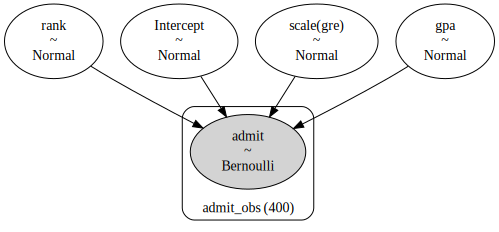

In [16]:
from scipy import special

# Construct likelihood distribution ------------------------------
# This must use a valid PyMC distribution name.
# 'parent' is the name of the variable that represents the mean of the distribution. 
# The mean of the Bernoulli family is given by 'p'.
likelihood = bmb.Likelihood("Bernoulli", parent="p")

# Set link function ----------------------------------------------
# There are two alternative approaches.
# 1. Pass a name that is known by Bambi
link = bmb.Link("logit")

# 2. Build everything from scratch
# link: A function that maps the response to the linear predictor
# linkinv: A function that maps the linear predictor to the response
# linkinv_backend: A function that maps the linear predictor to the response
#                  that works with PyTensor tensors.
#                  bmb.math.sigmoid is a PyTensor tensor function wrapped by PyMC and Bambi 
link = bmb.Link(
    "my_logit", 
    link=special.logit,
    linkinv=special.expit,
    linkinv_backend=bmb.math.sigmoid
)

# Construct the family -------------------------------------------
# Families are defined by a name, a Likelihood and a Link.
family = bmb.Family("bernoulli", likelihood, link)

# Now it's business as usual
# Note: 'gre' is standardized to mean 0 and variance 1
model = bmb.Model("admit ~ scale(gre) + gpa + rank", data, family=family)
model.build()
model.graph()

In [17]:
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, scale(gre), gpa, rank]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


The above example produces results identical to simply setting `family='bernoulli'`.

One complication in specifying a custom `Family` is that one must pass both a link function and an inverse link function which must be able to operate over PyTensor tensors rather than numpy arrays, so you'll probably need to rely on tensor operations provided in `pytensor.tensor` (many of which are also wrapped by PyMC) when defining a new link.

## Results

When a model is fitted, it returns a ``InferenceData`` object containing data related to the model and the posterior. This object can be passed to many functions in ArviZ to obtain numerical and visuals diagnostics and plot in general.


## Plotting


To visualize a plot of the posterior estimates and sample traces for all parameters, simply pass the ``InferenceData`` object to  the arviz function ``az._plot_trace``:

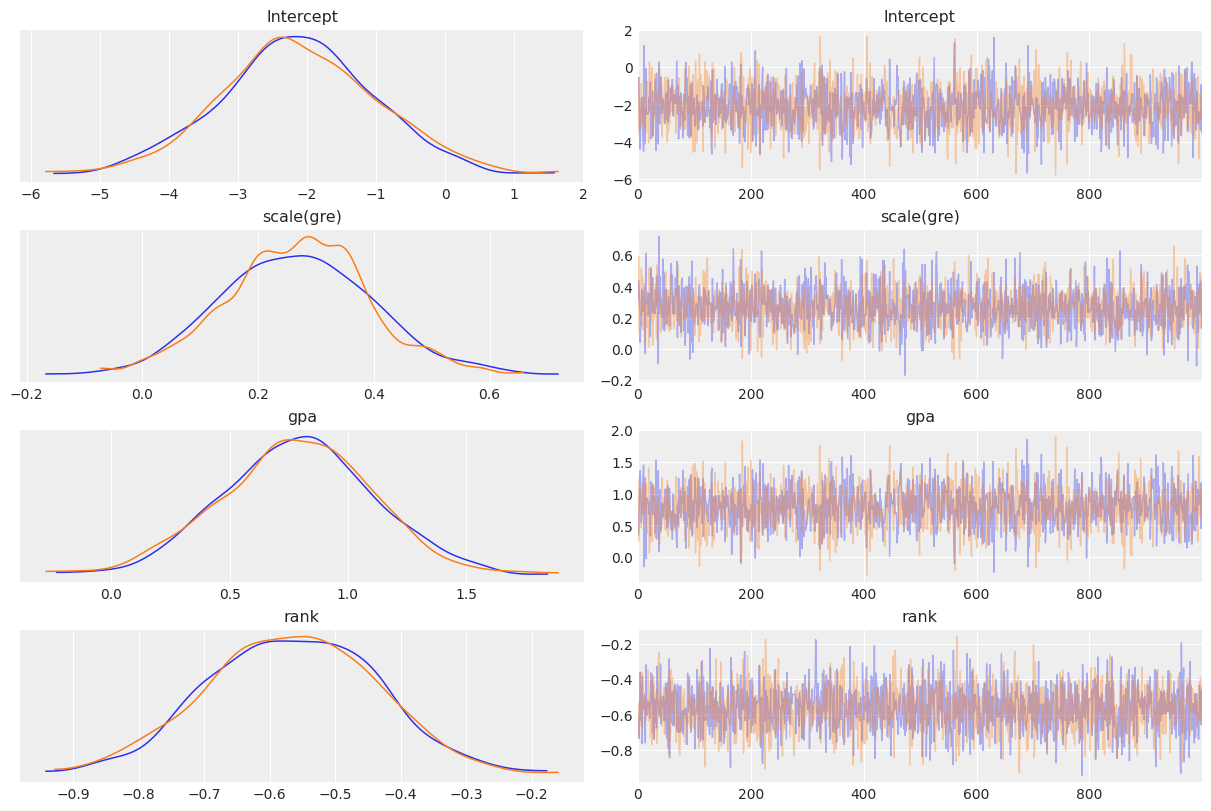

In [18]:
az.plot_trace(results, compact=False);

More details on this plot are available in the [ArviZ documentation](https://python.arviz.org/en/latest/api/generated/arviz.plot_trace.html).

## Summarizing

If you prefer numerical summaries of the posterior estimates, you can use the ``az.summary()`` function from [ArviZ](https://python.arviz.org/en/latest/api/generated/arviz.summary.html)  which provides a pandas DataFrame with some key summary and diagnostics info on the model parameters, such as the 94% highest posterior density intervals

In [19]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.129,1.139,-4.216,0.117,0.024,0.017,2245.0,1512.0,1.0
scale(gre),0.268,0.126,0.024,0.496,0.003,0.002,2321.0,1658.0,1.0
gpa,0.787,0.323,0.131,1.335,0.007,0.005,2119.0,1439.0,1.0
rank,-0.566,0.129,-0.813,-0.332,0.003,0.002,2584.0,1778.0,1.0


If you want to view summaries or plots for specific parameters, you can pass a list of its names:

In [20]:
# show the names of all variables stored in the InferenceData object
list(results.posterior.data_vars)

['Intercept', 'scale(gre)', 'gpa', 'rank']

You can find detailed, worked examples of fitting Bambi models and working with the results in the example notebooks [here](../examples.html).

## Accessing back-end objects

Bambi is just a high-level interface to PyMC. As such, Bambi internally stores virtually all objects generated by PyMC, making it easy for users to retrieve, inspect, and modify those objects. For example, the ``Model`` class created by PyMC (as opposed to the Bambi class of the same name) is accessible from `model.backend.model`.

In [21]:
type(model.backend.model)

pymc.model.core.Model

In [22]:
model.backend.model

 Intercept ~ Normal(0, 23.4)
scale(gre) ~ Normal(0, 2.5)
       gpa ~ Normal(0, 6.58)
      rank ~ Normal(0, 2.65)
     admit ~ Bernoulli(f(Intercept, rank, gpa, scale(gre)))

In [23]:
model.backend.model.observed_RVs

[admit ~ Bernoulli(f(Intercept, rank, gpa, scale(gre)))]

In [24]:
model.backend.model.unobserved_RVs

[Intercept ~ Normal(0, 23.4),
 scale(gre) ~ Normal(0, 2.5),
 gpa ~ Normal(0, 6.58),
 rank ~ Normal(0, 2.65)]

In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Nov 11 2023

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

arviz : 0.16.1
scipy : 1.11.2
bambi : 0.13.1.dev7+gc6e5dbb5.d20231111
numpy : 1.23.4
pandas: 2.1.0

Watermark: 2.4.3

